In [8]:
from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

In [9]:
N = 30 # number of iterations
dt = 1.0 # time step
R_std = 0.35
Q_std = 0.04

M_TO_FT = 1 / 0.3048

In [10]:
sensor = PosSensor((0, 0), (2, .5), noise_std=R_std)
sensor

In [11]:
import numpy as np
zs = np.array([sensor.read() for _ in range(N)])
zs

array([[ 2.31434876,  1.02902568],
       [ 3.78303124,  1.61805979],
       [ 6.35252211,  1.54541947],
       [ 7.4738952 ,  1.87738963],
       [10.29904539,  2.35934735],
       [12.65781882,  3.6989692 ],
       [14.35948375,  3.92654624],
       [16.16245542,  3.35227499],
       [17.95112672,  4.96078544],
       [19.62717941,  5.2195561 ],
       [21.79566423,  5.29622735],
       [23.86878511,  5.68411949],
       [25.98951996,  6.67047837],
       [27.67772894,  6.63283441],
       [29.92294929,  7.35921956],
       [31.99826358,  8.24060818],
       [33.63441685,  9.19541138],
       [35.82159379,  8.97982561],
       [37.57366478,  9.04262407],
       [39.89480071,  9.97755689],
       [41.72984352, 10.70750564],
       [44.45697295, 11.68086055],
       [45.76515617, 11.43051426],
       [48.15931563, 11.99158872],
       [50.19206917, 12.48471107],
       [52.197973  , 12.79011634],
       [53.80007216, 14.01372482],
       [56.30725627, 14.25173106],
       [58.29910877,

In [12]:
from filterpy.kalman import KalmanFilter

tracker = KalmanFilter(dim_x=4, dim_z=2)

tracker.F = np.array([[1, 0, dt,  0],
                      [0, 1,  0, dt],
                      [0, 0,  1,  0],
                      [0, 0,  0,  1]])

tracker.H = np.array([[M_TO_FT, 0, 0, 0],
                      [0, M_TO_FT, 0, 0]])

tracker.R = np.eye(2) * R_std**2

In [14]:
from filterpy.common import Q_discrete_white_noise
q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
q

array([[0.0004, 0.0008],
       [0.0008, 0.0016]])

In [15]:
tracker.Q[0,0] = q[0,0]
tracker.Q[1,1] = q[0,0]
tracker.Q[2,2] = q[1,1]
tracker.Q[3,3] = q[1,1]
tracker.Q[0,2] = q[0,1]
tracker.Q[2,0] = q[0,1]
tracker.Q[1,3] = q[0,1]
tracker.Q[3,1] = q[0,1]

In [16]:
tracker.Q

array([[0.0004, 0.    , 0.0008, 0.    ],
       [0.    , 0.0004, 0.    , 0.0008],
       [0.0008, 0.    , 0.0016, 0.    ],
       [0.    , 0.0008, 0.    , 0.0016]])

In [17]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

In [18]:
xs, ys = [], []
for z in zs:
    tracker.predict()
    tracker.update(z)
    xs.append(tracker.x[0])
    ys.append(tracker.x[1])

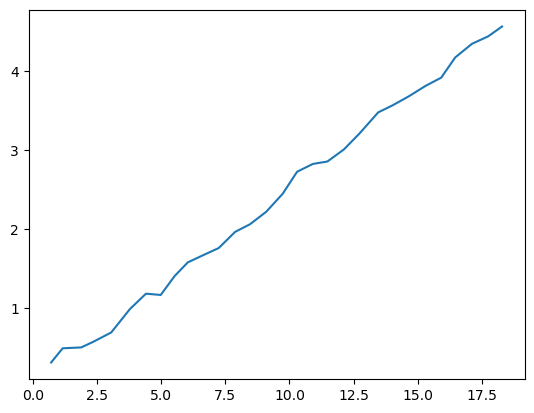

In [21]:
import matplotlib.pyplot as plt
plt.plot(xs, ys)

In [22]:
from filterpy.common import kinematic_kf

kf = kinematic_kf(dim=2, order=1, dt=1.0, order_by_dim=False)
kf.Q = np.diag([0, 0, .003, .003])
kf.x = np.array([[1., 1., 0., 0.]]).T
kf.R = np.diag([0.03, 0.21]) # use different errors

In [23]:
kf.F

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [26]:
for i in range(101):
    kf.predict()
    kf.update(np.array([[i*.05, i*.05]])) # around 200 kph

In [27]:
p0 = kf.x[0:2]

kf.predict()
prior = kf.x
z = kf.x[0:2]*2
kf.update(z)
p1 = kf.x[0:2]

# compute error of measurement from prior
y = np.abs(z - kf.H @ prior)
dist = np.linalg.norm(y)

np.set_printoptions(precision=2, suppress=True)

print(f'bad measurement       : {z.T} km')
print(f'before bad measurement: {p0.T} km')
print(f'after bad measurement : {p1.T} km')
print(f'estimate shift        : {np.linalg.norm(p1 - prior[:2]):.1f} km')
print(f'distance from prior   : {dist:.1f} km')

bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[7.84 7.01]] km
estimate shift        : 3.4 km
distance from prior   : 7.1 km


In [28]:
print(f'error = {np.linalg.norm(kf.y):.1f} km, at a speed of {dist*3600:.0f} kph')

error = 7.1 km, at a speed of 25710 kph


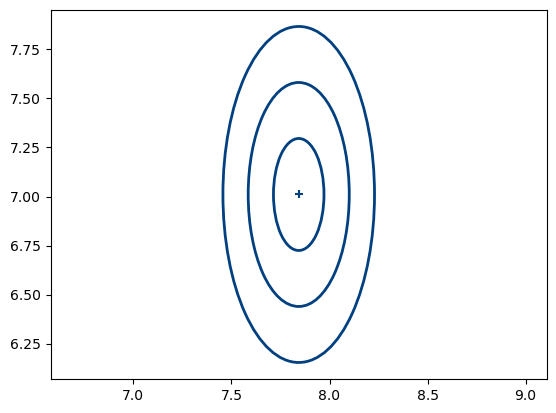

In [29]:
from filterpy.stats import plot_covariance_ellipse
x, P = kf.x[0:2], kf.P[0:2, 0:2]
plot_covariance_ellipse(x, P, std=[1,2,3])



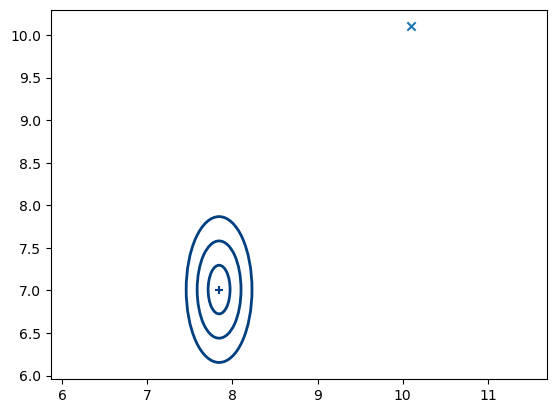

In [30]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(z[0], z[1], marker='x')

In [31]:
GATE_LIMIT = 4.
std_x = np.sqrt(P[0,0])
std_y = np.sqrt(P[1,1])
y = kf.residual_of(z)[:,0]
y

array([5.05, 5.05])

In [32]:
if y[0] > GATE_LIMIT * std_x or y[1] > GATE_LIMIT * std_y:
    print(f'discarding measurement, error is {y[0]/std_x:.0f} std, {y[1]/std_y:.0f} std')
    
print('y   is', y)
print(f'std is {std_x:.2f} {std_y:.2f}')

discarding measurement, error is 39 std, 18 std
y   is [5.05 5.05]
std is 0.13 0.29


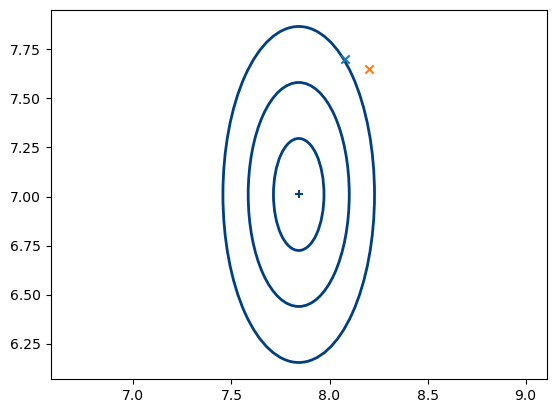

In [33]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(8.08, 7.7, marker='x')
plt.scatter(8.2, 7.65, marker='x')

In [34]:
from filterpy.stats import mahalanobis
m = mahalanobis(x=z, mean=x, cov=P)
print(f'mahalanobis distance = {m:.1f}')

mahalanobis distance = 20.6


In [35]:
print(f'mahalanobis distance = {mahalanobis(x=[8.08, 7.7], mean=x, cov=P):.1f}')
print(f'mahalanobis distance = {mahalanobis(x=[8.2, 7.65], mean=x, cov=P):.1f}')

mahalanobis distance = 3.0
mahalanobis distance = 3.6


In [36]:
dt = 1.
R = 3.
kf = KalmanFilter(dim_x=2, dim_z=1, dim_u = 1)
kf.P *= 10
kf.R *= R
kf.Q = Q_discrete_white_noise(2, dt, 0.1)
kf.F = np.array([[1., 0], [0., 0.]])
kf.B = np.array([[dt], [ 1.]])
kf.H = np.array([[1., 0]])
print(kf.P)

[[10.  0.]
 [ 0. 10.]]


In [37]:
zs = [i + randn()*R for i in range(1, 100)]
xs = []
cmd_velocity = np.array([1.])

In [38]:
for z in zs:
    kf.predict(u=cmd_velocity)
    kf.update(z)
    xs.append(kf.x[0])

Text(0, 0.5, 'distance')

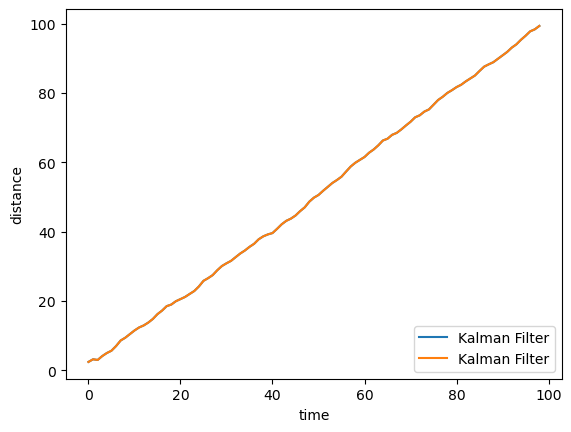

In [41]:
plt.plot(xs, label='Kalman Filter')
plt.xlabel('time')
plt.legend(loc=4)
plt.ylabel('distance')

In [65]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout

def hx(x):
    return x[:1] # return position [x] 

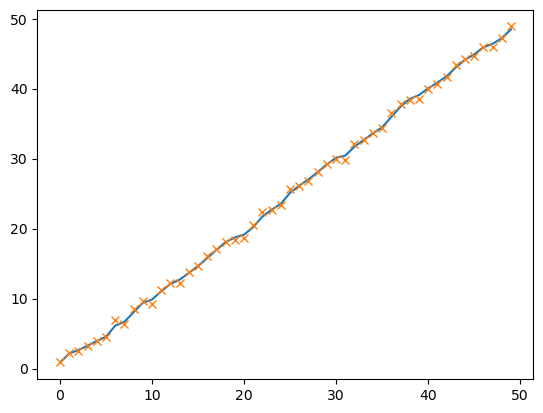

In [75]:
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=2, kappa=1)

from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P *= 10
ukf.R *= .5
ukf.Q = Q_discrete_white_noise(2, dt=1., var=0.03)

zs, xs = [], []
for i in range(50):
    z = i + randn()*.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)
    
plt.plot(xs)
plt.plot(zs, marker='x', ls='')


In [77]:
def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

In [83]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats
from kf.kf_book.nonlinear_plots import plot_monte_carlo_mean


#initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.empty((5, 2))


array([[ 0.  ,  0.  ],
       [ 2.46,  1.15],
       [ 0.  ,  2.5 ],
       [-2.46, -1.15],
       [ 0.  , -2.5 ]])

Difference in mean x=-0.097, y=0.549


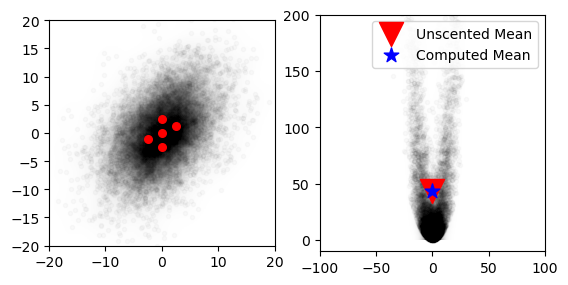

In [84]:
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

#generate random points
np.random.seed(100)
xs, ys = np.random.multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30);

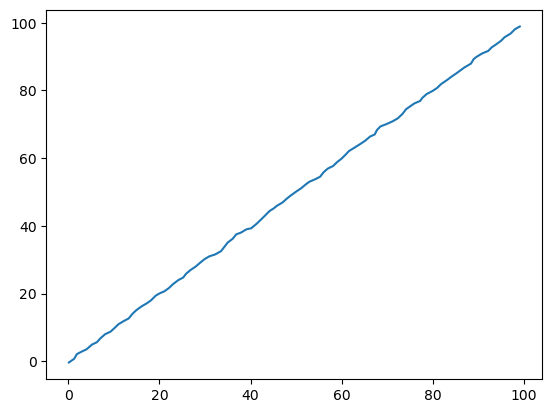

In [90]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

std_x, std_y = .3, .3
dt = 1.0

np.random.seed(1234)
kf = KalmanFilter(4, 2)
kf.x = np.array([0., 0., 0., 0.])
kf.R = np.diag([std_x**2, std_y**2])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])
 
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)
# kf.Q

zs = [np.array([i + randn()*std_x, 
                i + randn()*std_y]) for i in range(100)]               
xs, _, _, _ = kf.batch_filter(zs)
plt.plot(xs[:, 0], xs[:, 2])

In [95]:
def f_cv(x, dt):
    """ state transition function for a 
    constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return F @ x

def h_cv(x):
    return x[[0, 2]]

UKF standard deviation 0.013 meters


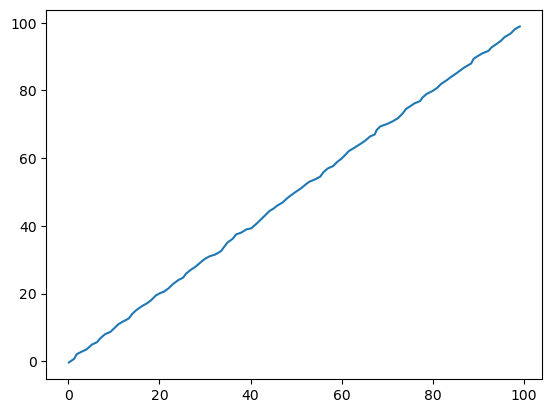

In [103]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

import numpy as np

sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

uxs = []
for z in zs:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

plt.plot(uxs[:, 0], uxs[:, 2])
print(f'UKF standard deviation {np.std(uxs - xs):.3f} meters')